# Análise de Churn

Vou criar um modelo de análise de Churn de um banco da região sul do Brasil. Serão buscadas possíveis tendências, desvios, padrões de comportamento e outros insights que favoreçam ao negócio, tanto na tomada de medidas para redução dos cancelamentos quanto no aumento da receita.

## Objetivo

O objetivo principal do modelo será prever os clientes com maior probabilidade de deixar o banco, para que hajam ações de contorno com esses clientes e o cancelamento possa ser revertido, senão, remediado.

## Limpeza e tratamento de dados

Vou utilizar os critérios abaixo na limpeza dos dados, onde buscarei validar e corrigir possíveis duplicidades, inconsistências, incompletudes e inconformidades nos dados.
Com isso, vou garantir a integridade dos dados para criar um modelo com o mínimo enviesamento possível a partir da base disponível.

### 1.0 Importando bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import statistics as sts

A biblioteca **pandas** será importada para tratar os dados de forma tabular, como um DataFrame (df).

A biblioteca **seaborn** será importada para a visualização dos dados na etapa de exploração dos dados limpos.

A biblioteca **statistics** será importada para alguns cálculos de distribuição e detecção de outliers.

### 1.1 Compreendendo o dataset

Para compreender o dataset, primeiramente preciso importá-lo, verificar tamanho e atributos. A partir daí, posso iniciar o tratamento das inconsistências encontradas. 

In [2]:
# O dataset será importado e lido pelo Pandas como um DataFrame, a nomenclatura será df.
df = pd.read_csv("Churn.csv", sep=";")
# Visualização dos dados importados
df.head()

,X0,X1,X2,X3,X4,X4.1,X6,X7,X8,X9,X10,X11
0,1,619,RS,Feminino,42,2,0,1,1,1,10134888.0,1
1,2,608,SC,Feminino,41,1,8380786,1,0,1,11254258.0,0
2,3,502,RS,Feminino,42,8,1596608,3,1,0,11393157.0,1
3,4,699,RS,Feminino,39,1,0,2,0,0,9382663.0,0
4,5,850,SC,Feminino,43,2,12551082,1,1,1,790841.0,0


As colunas possuem nomes que não fazem sentido. Antes de analisar e tratar isso, quero entender o tamanho do dataset (linhas x colunas):

In [3]:
df.shape

(999, 12)

O dataset tem 999 linhas e 12 colunas.

### 1.2 Dicionário dos dados

O banco forneceu o dicionário das colunas, :
- id: Código de identificação de cada cliente.
- score: Pontuação do cliente no sistema de crédito do banco, quanto maior, melhor.
- estado: Estado (UF) da agência do cliente.
- genero: Gênero do cliente (feminino, masculino).
- idade: Idade do cliente.
- patrimonio: Quantidade de patrimônios declarados pelo cliente.
- saldo: Saldo na conta do cliente.
- produtos: Produtos do banco adquiridos ou assinados pelo cliente.
- temcartcredito: Possui cartão de crédito do banco (1 = sim, 0 = não).
- ativo: Conta ativa no banco (1 = sim, 0 = não).
- salario: Salário mensal do cliente, recebido no banco.
- excliente: Cliente cancelou a conta (churn) (1 = sim, 0 = não).

In [4]:
df.columns = ["id","score","estado",'genero','idade','patrimonio','saldo','produtos','temcartcredito','ativo','salario','excliente']
df.head()

,id,score,estado,genero,idade,patrimonio,saldo,produtos,temcartcredito,ativo,salario,excliente
0,1,619,RS,Feminino,42,2,0,1,1,1,10134888.0,1
1,2,608,SC,Feminino,41,1,8380786,1,0,1,11254258.0,0
2,3,502,RS,Feminino,42,8,1596608,3,1,0,11393157.0,1
3,4,699,RS,Feminino,39,1,0,2,0,0,9382663.0,0
4,5,850,SC,Feminino,43,2,12551082,1,1,1,790841.0,0


Antes de continuar a limpeza, é preciso compreender qual o tipo de dado de cada coluna, para posteriormente tratar de forma separada os dados categóricos e numéricos.
Para isso, será retornado o valor info() de todas as colunas.

### 1.3 Informações Gerais

Agora, vou avaliar as principais informações sobre os dados, desde os tipos, classes e possíveis problemas que vão exigir limpeza e tratamento. Este processo de conhecer os dados com os quais lidamos, costuma ser subestimado, porém, é de grande relevância e evita muitos problemas futuros.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              999 non-null    int64  
 1   score           999 non-null    int64  
 2   estado          999 non-null    object 
 3   genero          991 non-null    object 
 4   idade           999 non-null    int64  
 5   patrimonio      999 non-null    int64  
 6   saldo           999 non-null    int64  
 7   produtos        999 non-null    int64  
 8   temcartcredito  999 non-null    int64  
 9   ativo           999 non-null    int64  
 10  salario         992 non-null    float64
 11  excliente       999 non-null    int64  
dtypes: float64(1), int64(9), object(2)
memory usage: 93.8+ KB


Com as informações de classificação das colunas, a utilização dos dados será mais proveitosa desde a limpeza.

**Colunas categóricas:** estado, genero.

**Colunas numéricas:** id, score, idade, patrimonio, saldo, produtos, temcartcredito, ativo, salario, excliente.

Todas as colunas numéricas têm propriedade _int64_(números inteiros), exceto a coluna salario, que possui valor _float64_(número decimal). Posteriormente isso será tratado.

O tratamento será iniciado com as colunas categóricas.

estado
PR    257
RP      1
RS    478
SC    258
SP      4
TD      1
dtype: int64


<Axes: xlabel='estado'>

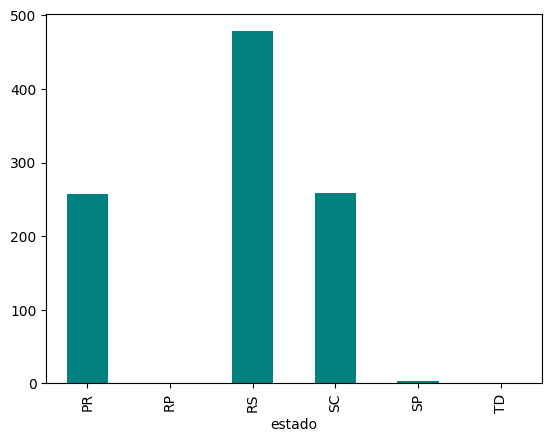

In [6]:
# Agrupamento dos dados da coluna estado:
estado = df.groupby(['estado']).size()
# Totais
print(estado)
# Visualização gráfica
estado.plot.bar(color='teal')

O primeiro problema encontrado é a **inconformidade** dos dados, pois "PR" (Paraná) aparentemente foi inserido errado pelo usuário na captação desse dado "RP". Além disso, a **integridade** também foi ferida, afinal, o estado TD não existe e o estado SP (São Paulo) não fica na região Sul do Brasil, mas sim no Sudeste.

Agora, o mesmo processo será realizado com a coluna _genero_:

genero
F              2
Fem            1
Feminino     461
M              6
Masculino    521
dtype: int64


<Axes: xlabel='genero'>

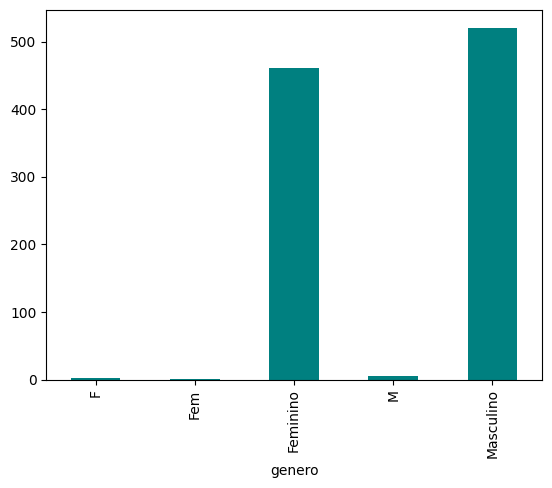

In [7]:
# Agrupamento dos dados da coluna genero:
genero = df.groupby(['genero']).size()
# Totais
print(genero)
# Visualização gráfica
genero.plot.bar(color='teal')

Também há inconformidade no preenchimento dos gêneros, "Feminino", "F" e "Fem" terão o mesmo valor para o modelo, assim como "M" e "Masculino". Isso também será tratado posteriormente.

Agora, vou verificar as colunas numéricas:

In [8]:
# Visualização numérica
df['score'].describe()

count    999.000000
mean     648.621622
std       98.264219
min      376.000000
25%      580.000000
50%      653.000000
75%      721.000000
max      850.000000
Name: score, dtype: float64

<Axes: ylabel='score'>

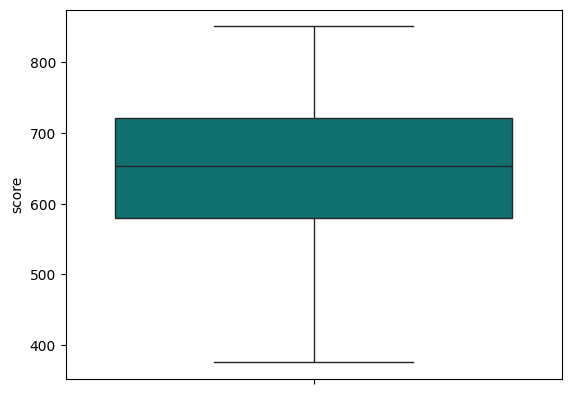

In [9]:
# Visualização gráfica
sns.boxplot(df['score'], color = 'teal', orient='v')

<Axes: xlabel='score', ylabel='Count'>

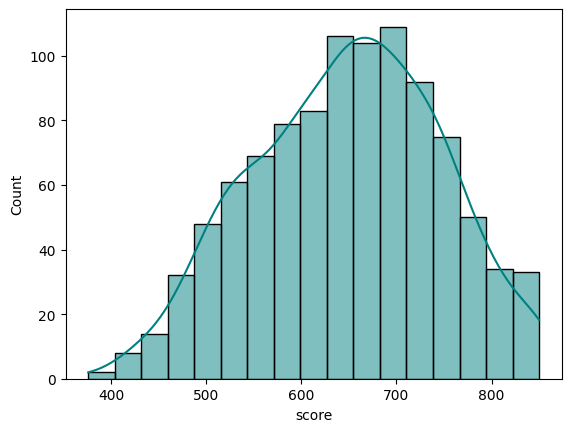

In [10]:
sns.histplot(df['score'], color = 'teal', kde=True)

- A menor pontuação existente é 376 pontos, a maior, 850 pontos.
- Há uma distribuição regular entre os dados, 
- A média (mean) é 648 pontos.
- A mediana (50%) é 653 pontos.
- Quanto mais próximos os valores de média e mediana, menor a probabilidade de outliers no dataset.

Agora, vou visualizar as informações da coluna idade:

In [11]:
# Visualização numérica
df['idade'].describe()

count    999.000000
mean      38.902903
std       11.401912
min      -20.000000
25%       32.000000
50%       37.000000
75%       44.000000
max      140.000000
Name: idade, dtype: float64

<Axes: ylabel='idade'>

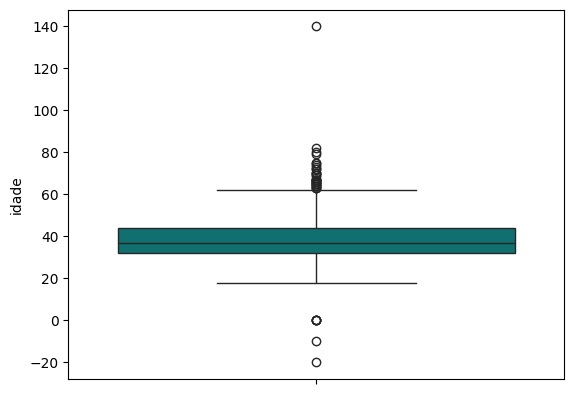

In [14]:
# Visualização gráfica
sns.boxplot(df['idade'], color = 'teal', orient='v')

<Axes: xlabel='idade', ylabel='Count'>

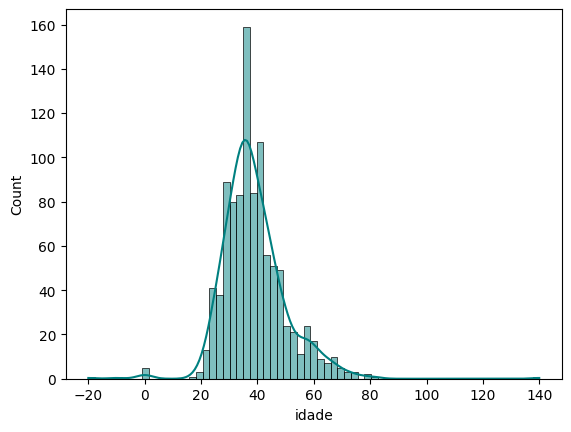

In [15]:
sns.histplot(df['idade'], color = 'teal', kde=True)

É possível observar que.